    Data analysis of nextnano++ output and programatic control of the input files

        the code was tested with nextnano 2023_08_07 and specifically with nextnano++
        there are multiple programs:
            -load and plot .h5 file
            -nextnanopy with few e- tuning routine, .h5 export, plotting of the data
            -3d model generator for the gatestack, based on the input of several gate layers and heights(very inperformant, run at your own risk)
            
        some todos:
            -create visual overlay based on the input file
            -make the overlay interactive and editable, so one can change the layout slightly with mouse or text inputs
            -refactoring of the code
            -rewrite the 3d model generator to use USD and fix some bugs in the visuals
            

h5 plotter, was written to plot the .h5 of the adwin sweep from the lab
can be extended to plot any  h5 file, as long as the data structure is known

In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Open the .h5 file
filename = "C:/Users/riesn/Desktop/BachelorArbeit/Abschlusspräsi/Check1-Leverarm/170333_2D_Coulomb_diamonds_Gate_8.h5"
with h5py.File(filename, 'r') as hdf:
    # List all groups
    print(list(hdf.keys()))
    

    # Assuming there's a dataset named 'data' inside the file
    x = hdf['entry/data0/gate_8'][:]
    y = hdf['entry/data0/gate_24'][:]

    Xx,Yy= np.meshgrid(x,y)
    z = hdf['entry/data0/adwin1.current'][:]
    print(z)
    #print(hdf['entry/data0'].keys())


    X_trimmed = x[:z.shape[0]+1]
    #y=
    y_with_zero = np.insert(y, 0, 0)
    y_with_zero= ((y_with_zero - 0.207)/100)*1000
    y
cdict = {'red':   [[0.0,  0.0, 0.0],
                   [0.5,  1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'green': [[0.0,  0.0, 0.0],
                   [0.25, 0.0, 0.0],
                   [0.75, 1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'blue':  [[0.0,  0.0, 0.0],
                   [0.5,  0.0, 0.0],
                   [1.0,  1.0, 1.0]]}

# Assuming 'data' is a 2D numpy array
plt.pcolormesh(X_trimmed,y_with_zero,z.T/10, shading='auto', cmap='RdGy',vmin=-(0.25)*1e-10,vmax=(0.25)*1e-10)

# Add a color bar to show the scale of Z values
plt.colorbar(label='Current in A')
plt.xlim([1.68, 1.99])  # Replace xmin and xmax with your desired range for the x-axis
plt.ylim([-0.8,0.8])
# Label axes
plt.xlabel('P1 in V')
plt.ylabel('Bias voltage in mV')
plt.title('Coulomb oszillation')

# Display the plot
plt.show()
plt.savefig('Ctest.png')

----------------------
The nextnanopy implementation:
    -plot a 2d crosssection
        *no 3d support yet, has to be a crosssection that is defined in nextnano via \
        \
            section2D\
            {\
                name="your region name\
                z=where to take the slice\
            }\
            \
    -save to h5
        *lets you save the nextnano output as an h5 file
    -loading and saving to the same h5 file in one notebook session is really buggy and causes issues
            

{'exe': 'C:/Users/riesn/Desktop/BachelorArbeit/nextnano/Version/2023_08_07/nextnano++/bin 64bit/nextnano++_Intel_64bit.exe', 'license': 'C:/Users/riesn/Documents/nextnano/License_nnp.lic', 'database': 'C:/Users/riesn/Desktop/BachelorArbeit/nextnano/Version/2023_08_07/nextnano++/Syntax/database_nnp.in', 'outputdirectory': 'D:/Nextnano/Output/test', 'threads': 0}
G:/Nextnano/post/IMEC-splitP1-gap-P1-sweeps-15x2nm-_V_P1_0.7.in
DictList([
(index: 0 - key: 'DomainXstart' - $DomainXstart = -154),
(index: 1 - key: 'DomainXend' - $DomainXend = 215),
(index: 2 - key: 'DomainYstart' - $DomainYstart = -140),
(index: 3 - key: 'DomainYend' - $DomainYend = 160),
(index: 4 - key: 'GATE_OVERLAP' - $GATE_OVERLAP = 10),
(index: 5 - key: 'DOTW' - $DOTW = 60),
(index: 6 - key: 'DOTH' - $DOTH = 60),
(index: 7 - key: 'SETDW' - $SETDW = 70),
(index: 8 - key: 'SETDH' - $SETDH = 70),
(index: 9 - key: 'SETBW' - $SETBW = 30),
(index: 10 - key: 'P2P_GAP' - $P2P_GAP = 40),
(index: 11 - key: 'RC_OVERLAP' - $RC_OVER

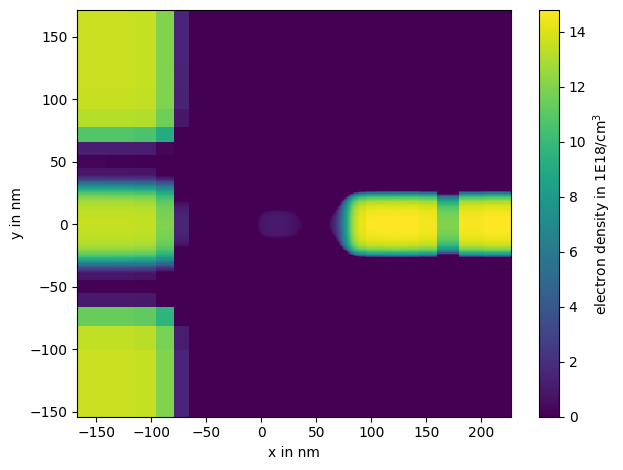

In [2]:
#nextnanopy
#implementation tested on nextnano 2023_08_07 nextnano++
#runs a tuning routine to get the voltages of a plunger, or set of plunger to form a qd underneath the combined plunger mass in the few electron regime
#simple step line search with upper and lower bounds and a initial guess
#voltages range from 0 to 3.5 with a good guess of 0.5 for the SiMOS device with poly silicon gates


import nextnanopy as nn 
import matplotlib.pyplot as plt
import h5py
from scipy import integrate



def plotFile(datafile_2d,x,y,var):
    x=datafile_2d.coords[x]
    y=datafile_2d.coords[y]
    z=datafile_2d.variables[var]


    fig, ax = plt.subplots(1)
    pcolor = ax.pcolormesh(x.value, y.value, z.value.T)
    cbar = fig.colorbar(pcolor)
    cbar.set_label(r'electron density in $1\text{E}18/\text{cm}^3$')
    ax.set_xlabel(r'x in nm')
    ax.set_ylabel(r'y in nm')

    fig.tight_layout()

def ploth5File(x,y,var):
    fig, ax = plt.subplots(1)
    pcolor = ax.pcolormesh(x, y, var)
    cbar = fig.colorbar(pcolor)
    cbar.set_label(r'electron density in $1\text{E}18/\text{cm}^3$')
    ax.set_xlabel(r'x in nm')
    ax.set_ylabel(r'y in nm')

    fig.tight_layout()

# create h5 file and save the data to it
def saveH5_2d(name,dat2D,var,x,y):
    hf = h5py.File(name + '.h5', 'w')
    g1 = hf.create_group('data')
    g1.create_dataset('x',data= dat2D.coords[x].value)
    g1.create_dataset('y',data= dat2D.coords[y].value)
    g1.create_dataset('density',data= dat2D.variables[var].value.T)
    hf.close

def loadH5_2d(filePath):
    with h5py.File(filePath, 'r') as hdf:
        
        # Assuming there's a dataset named 'data' inside the file
        x = hdf['entry/data/x'][:]
        y = hdf['entry/data/y'][:]
        z = hdf['entry/data0/density'][:]
        hdf.close
    
    return x,y,z 

def fewElectronRegime(dat3D,var):
    elec=0
    intX=[]
    lX=[]
    for idxX in range(0,len(dat3D.coords['x'].value)-1):
        intY=[]
        lY=[]
        for idxY in range(0,len(dat3D.coords['y'].value)-1):
            intZ=[]
            lZ=[]
            for idxZ in range(0,len(dat3D.coords['z'].value)-1):
                #this needs to be adjusted if you move the area of the dot formation. this is for a dot that forms within the x[-30,60] y[-30,30] z[0,20] domain
                # format is:           lower bound                               upper bound
                if(dat3D.coords['x'].value[idxX]>=-30 and dat3D.coords['x'].value[idxX]<=60 and
                   dat3D.coords['y'].value[idxY]>=-30 and dat3D.coords['y'].value[idxY]<=30 and
                   dat3D.coords['z'].value[idxZ]>=0   and dat3D.coords['z'].value[idxZ]<=20     ):
                    #append the values to lists, values for the density is e*1E18/cm^3
                    #lZ is in nm, convert to cm
                    lZ.append(dat3D.coords['z'].value[idxZ]*1E-7)
                    #add units to the scalars
                    intZ.append(dat3D.variables[var].value[idxX][idxY][idxZ]*1E18)
            #check if list has any entries, since there might not be any electron density at the sampled location
            if(intZ):
                #if there is an electron density, append the y location to the corresponding list
                #and integrate the electron density in the z-direction
                lY.append(dat3D.coords['y'].value[idxY]*1E-7)
                intY.append(integrate.cumulative_trapezoid(intZ, x=lZ, axis=-1, initial=0)[-1])
        if(intY):
            lX.append(dat3D.coords['x'].value[idxX]*1E-7)
            intX.append(integrate.cumulative_trapezoid(intY, x=lY, axis=-1, initial=0)[-1])
    #if there wasn no dot, you will get 0 here, but if there was a dot, electrons will return non 0
    if(intX):
        elec=integrate.cumulative_trapezoid(intX, x=lX, axis=-1, initial=0)[-1]
        
    return elec

#list of variables
P1Voltage=0.5

outputDir=r'D:/Nextnano/Output/test'


#check the config file for nn++
print(nn.config.get_options('nextnano++'))

#edit settings for the config
nn.config.set('nextnano++','exe',r'C:/Users/riesn/Desktop/BachelorArbeit/nextnano/Version/2023_08_07/nextnano++/bin 64bit/nextnano++_Intel_64bit.exe')

#fun fact, the license is time coded but changing the system date to before the expiry fixes this and you can use the expired license
nn.config.set('nextnano++','license',r'C:/Users/riesn/Documents/nextnano/License_nnp.lic')
nn.config.set('nextnano++','database',r'C:/Users/riesn/Desktop/BachelorArbeit/nextnano/Version/2023_08_07/nextnano++/Syntax/database_nnp.in')
nn.config.set('nextnano++','outputdirectory',outputDir)

#permanently update the config
nn.config.save()

#load input file, each input file also gets their own config file, which is a copy of the standard input file defined above
my_input = nn.InputFile(r'G:/Nextnano/post/IMEC-splitP1-gap-P1-sweeps-15x2nm-_V_P1_0.7.in')
#print(my_input.config) #use print to see if the config has the correct entries

inputFileName=my_input.filename[:-3]
print(my_input.fullpath)
print(my_input.variables) #all the variables are stored in this field


#Start of algo to minimize to few electron regime

bConverged=False

#initial guess
startingVoltage=0.74
#step size of the search, if the 0.5V are too low, the searchStep gets added, so 0.6 is next, till the few electron regime is either reached or overshot
searchStep=0.1
runID=0
P1Voltage=startingVoltage
runOutDir=outputDir
lowerBound=0.
upperBound=3.5
while(not bConverged):
    electrons = 0
    print('starting iteration {0}'.format(runID))
    #run first iteration with starting voltage    
    
    #change a single variable by name assigned
    #in this case we want to optimized the plunger voltage of the split plunger
    my_input.set_variable('V_P1', value=P1Voltage)
    my_input.set_variable('V_P1M', value=P1Voltage)

    #need to save the file in order for nn to run it properly...took me like 2h to figure this one out, overwrites the old one, since we only want to have the final input file
    my_input.save(overwrite=True)
    print('Variables V_P1 and V_P1M set to {0} '.format(my_input.get_variable('V_P1')))
    
    #if you dont want to save all the intermediate simulations, removing the runID from the output dir will result in the sims overwriting each other, saving space
    runOutDir=outputDir+r'/'+str(runID)
    #runOutDir=outputDir
    
    print('starting simulation')
    
    # run the simulation once to get a baseline, limiting the number of threads to physical cpu cores is recommended
    my_input.execute(outputdirectory=runOutDir, threads=4, show_log=False)
    print('simulation step complete')
    
    #after the run is done, check the output file of the electron density for few electron regime
    datafile_3d= nn.DataFile(my_input.folder_output + r'/bias_00000/density_electron_2DEG_-1-20.vtr',product='nextnano++')
    
    #the data is stored in the field datafile_2d.coords['x'] / datafile_2d.coords['y'] / datafile_2d.coords['z'], which are in order of : deviceStart - deviceEnd
    electrons=fewElectronRegime(dat3D=datafile_3d,var='density_electron_2DEG_-1-20')
    
    #check if a dot was formed, if not, electrons = 0 and we need to increase the voltage,
    if(electrons==0 or electrons<1):
        lowerBound=P1Voltage
        P1Voltage+=searchStep
    
    #if the few electron regime was overshot by increasing the voltage by 0.1v, we halve that and subtract 0.05v from our current position.
    if(electrons>2):
        upperBound=P1Voltage
        searchStep/=2
        P1Voltage-=searchStep
        
    #P1Voltage and starting voltage will form our upper and lower bounds
    print('voltage {0}'.format(P1Voltage))
    print('lowerBound {0} and upperBound {1}'.format(lowerBound,upperBound))
    print('electrons {0}'.format(electrons))
    if(upperBound-lowerBound<0.01 or (electrons >1 and electrons <2)):
        bConverged=True
    runID+=1


print('final voltage: {0} V and the resulting electrons: {1}'.format(P1Voltage,electrons))

#plot the 2d slice, should be exported seperately in nextnano
datafile_2d= nn.DataFile(my_input.folder_output + r'/bias_00000/density_electron_2d_DEG_z_2.vtr',product='nextnano++')
    
plotFile(datafile_2d=datafile_2d,x='x',y='y',var='density_electron_2d_DEG_z_2')

saveH5_2d(name='testo',dat2D=datafile_2d,var='density_electron_2d_DEG_z_2',x='x',y='y')

#h5x,h5y,h5z=loadH5_2d(filePath=r'testo.h5')
#ploth5File(h5x,h5y,h5z)

#get list of coordinates and variables
#print(f"List of coordinates in the current datafile: {datafile_2d.coords}")
#print(f"List of variables in the current datafile: {datafile_2d.variables}")




-------------------------------------------------------------

In [ ]:
#read and plot elDensity.h5 file

import h5py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Open the .h5 file
#filename = "C:/Users/riesn/Desktop/BachelorArbeit/Abschlusspräsi/Check1-Leverarm/170333_2D_Coulomb_diamonds_Gate_8.h5"
#filename= 'elDensity.h5'
#filename='IMEC-splitP1-gap-P1-sweeps-15x2nm-_V_P1_0.7.h5'
file = h5py.File(filename,'r')
keys=list(file.keys())

print(keys)
    

x = file['data/x']
y = file['data/y']
z = file['data/density']

# Assuming 'data' is a 2D numpy array
plt.pcolormesh(x,y,z, shading='auto', cmap='viridis')
file.close()
# Add a color bar to show the scale of Z values
plt.colorbar(label=r'electron density in $1\text{E}18/\text{cm}^3$')
#plt.xlim([1.68, 1.99])  # Replace xmin and xmax with your desired range for the x-axis
#plt.ylim([-0.8,0.8])
# Label axes
plt.xlabel('x in nm')
plt.ylabel('y in nm')
plt.title('')

# Display the plot
plt.show()
plt.savefig('Ctest1.png')

---------------------------------------------
depracated old algo, was ported to nextnanopy.

offers similar results 

input is an array of filepaths to electron density files from nextnano++ 

output is the corresponding amount of electrons is the dot

In [ ]:
#read vtr file and integrate the over the electron density
#prints the number of electrons in the dot
#!WARNING magic numbers need to be fixed 
import numpy as np
import pyvista as pv
from scipy import integrate

#list of vtr files to integrate the electron densities for
file_paths={
            'C:/Users/riesn/Desktop/Neuer Ordner/IMEC-LAB_V_P1_0.8(1)/bias_00000/density_electron_2DEG_-1-20.vtr',
            'C:/Users/riesn/Desktop/Neuer Ordner/IMEC-LAB_V_P1_0.8/bias_00000/density_electron_2DEG_-1-20.vtr',
            'D:/Nextnano/Output/test/IMEC-splitP1-gap-P1-sweeps-15x2nm-_V_P1_0.7/0/IMEC-splitP1-gap-P1-sweeps-15x2nm-_V_P1_0.7/bias_00000/density_electron_2DEG_-1-20.vtr',
            
            }

for file_path in file_paths:
      grid = pv.read(file_path)
      print(file_path)

      #using pyvista to read the file and extract the nedded fields -> https://docs.pyvista.org/
      point_data=grid.point_data['density_electron_2DEG_-1-20']


      # Get the points from the dataset
      points = grid.points

      # Extract the X, Y, and Z coordinates
      pX = points[:, 0]
      pY = points[:, 1]
      pZ = points[:, 2]

      #reduce to unique entry lists
      unique_x = np.unique(pX)
      unique_y = np.unique(pY)
      unique_z = np.unique(pZ)

      #!WARNING Magic number, this is set in the simulation file and is the grid constant for the quantum region, which should be constant for the whole region
      #grid constant used for the quantum region, finest grid size-> needs to be a constant value inside the interval
      #this code works on the basis of a constant grid constant so we can get it by subtracting two neighboring z points
      gridConstZ = unique_z[3]-unique_z[2] #in nm

      #values defined in the nextnano input file, you need to set them manually or extract them for each file individually
      gridConstX=1 #in nm
      gridConstY=1 #in nm

      #index over the whole x*y dataset
      index=0

      #iterate over each coordinate point 
      listZ=[]
      for z in unique_z:
          index2=0
          listY=[]
          for y in unique_y:
              listX=[]
              for x in unique_x:
                  #electron density in 1e18/cm^3 and the grid constant is in nm
                  #if the area of the dot 
                  #the bounds of the area to integrate over, in this case the quantum region of the dot
                  if((x>=-30 and x<=50)and(y>=-30 and y<=30) and (z>=0 and z<=20) and (point_data[index]>1E-7)):
                        #create a list of x-values to integrate over
                        listX.append(point_data[index]*1E18)
                  index +=1
              if(listX):
               #print(listX)
               #dx is the distance between adjacent points, the grid constant for the area in question 1E-7cm = 1 nm 
               listY.append(integrate.cumulative_trapezoid(listX, x=None, dx=gridConstX*1E-7, axis=-1, initial=0)[-1])
          #if there are no values to integrate, skip
          if(listY):
           listZ.append(integrate.cumulative_trapezoid(listY,x=None, dx=gridConstY*1E-7, axis=-1, initial=0)[-1])  
           
      print("number of electrons")
      if(listZ):
          

          result=(integrate.cumulative_trapezoid(listZ,x=None, dx=gridConstZ*1E-7, axis=-1, initial=0)[-1])
          print(result)
      else:
           print(0)


------------
depracated model generator

In [ ]:
#creates a 3d model out of a stack of bitmaps that try to immitate layer deposition for visualizing the gatestack
from PIL import Image
import numpy as np
from stl import mesh
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def read_image_to_bitmap(file_path):
    """Read an image and convert it to a grayscale bitmap."""
    image = Image.open(file_path).convert('L')  # Convert to grayscale
    bitmap = np.array(image)  # Convert to numpy array
    return bitmap

def smooth_bitmap(bitmap, sigma=2):
    """Apply Gaussian smoothing to a bitmap."""
    smoothed_bitmap = gaussian_filter(bitmap, sigma=sigma)
    return smoothed_bitmap

def save_bitmap_to_image(bitmap, output_path):
    """Save a bitmap (numpy array) as a grayscale image."""
    image = Image.fromarray(bitmap)
    image.save(output_path)

def load_image_as_layer(image_path, layer_height, z_offset, scaled_array):
    """
    Load an image, convert it to a 3D layer, and apply the specified layer height and z offset.
    """
    # Load the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image_array = np.array(image)
    
    
    # Normalize the image values to 0 or 1 (binary)
    #image_array = (image_array > 128).astype(np.uint8)

    #smoothed_array=smooth_bitmap(image_array)


    # Create the vertices and faces for the current layer
    vertices = []
    faces = []
    dim_x, dim_y = image_array.shape
    
    for y in range(dim_y):
        for x in range(dim_x):
            if image_array[x, y] >0:  # Check if the pixel is part of the model
                # Define the 8 vertices of the voxel (cube)
                scale=image_array[x,y]/255 
                #print(scale)
                v0 = [x, y, z_offset+scaled_array[x,y]]
                v1 = [x+1, y, z_offset+scaled_array[x,y]]
                v2 = [x+1, y+1, z_offset+scaled_array[x,y]]
                v3 = [x, y+1, z_offset+scaled_array[x,y]]
                v4 = [x, y, z_offset + layer_height*scale+scaled_array[x,y]]
                v5 = [x+1, y, z_offset + layer_height*scale+scaled_array[x,y]]
                v6 = [x+1, y+1, z_offset + layer_height*scale+scaled_array[x,y]]
                v7 = [x, y+1, z_offset + layer_height*scale+scaled_array[x,y]]
                
                # Add vertices to the list
                base_index = len(vertices)
                vertices.extend([v0, v1, v2, v3, v4, v5, v6, v7])
                
                # Define the 12 faces of the voxel (2 triangles per face)
                faces.extend([
                    [base_index + 0, base_index + 1, base_index + 2], [base_index + 2, base_index + 3, base_index + 0],  # Bottom face
                    [base_index + 4, base_index + 5, base_index + 6], [base_index + 6, base_index + 7, base_index + 4],  # Top face
                    [base_index + 0, base_index + 1, base_index + 5], [base_index + 5, base_index + 4, base_index + 0],  # Front face
                    [base_index + 2, base_index + 3, base_index + 7], [base_index + 7, base_index + 6, base_index + 2],  # Back face
                    [base_index + 1, base_index + 2, base_index + 6], [base_index + 6, base_index + 5, base_index + 1],  # Right face
                    [base_index + 0, base_index + 3, base_index + 7], [base_index + 7, base_index + 4, base_index + 0],  # Left face
                ])
                scaled_array[x,y]+=image_array[x,y]/255*layer_height
    
    return np.array(vertices), np.array(faces)

def create_3d_model(image_paths, layer_heights):
    """
    Create a 3D model by stacking layers generated from a list of images and corresponding layer heights.
    """
    all_vertices = []
    all_faces = []
    z_offset = 0
    vertex_offset = 0

    first_image = Image.open(image_paths[0]).convert('L')
    dim_x, dim_y = first_image.size
    scaled_array = np.zeros((dim_y, dim_x))
    
    
    for image_path, layer_height in zip(image_paths, layer_heights):
        vertices, faces = load_image_as_layer(image_path, layer_height, z_offset,scaled_array)
        
        save_model_as_stl(vertices, faces, image_path+'.stl')

        # Adjust face indices based on the current vertex offset
        faces += vertex_offset
        
        all_vertices.append(vertices)
        all_faces.append(faces)
        
        #print(layer_height)
        #print(z_offset)
        # Update offsets for the next layer
        vertex_offset += vertices.shape[0]
        z_offset += layer_height
    
    all_vertices = np.concatenate(all_vertices)
    all_faces = np.concatenate(all_faces)
    
    return all_vertices, all_faces

def save_model_as_stl(vertices, faces, output_path):
    """
    Save the 3D model as an STL file.
    """
    model_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, face in enumerate(faces):
        for j in range(3):
            model_mesh.vectors[i][j] = vertices[face[j], :]
    
    model_mesh.save(output_path)

# Example usage:
image_paths = ['G:/Nextnano/oxide200.png','G:/Nextnano/oxide8.png','G:/Nextnano/layer1.png','G:/Nextnano/oxide5.png', 'G:/Nextnano/layer2.png','G:/Nextnano/oxide5_2.png', 'G:/Nextnano/layer3.png']
output_files = ['G:/Nextnano/oxide200_smoothed.png','G:/Nextnano/oxide8_smoothed.png','G:/Nextnano/layer1_smoothed.png','G:/Nextnano/oxide5_smoothed.png', 'G:/Nextnano/layer2_smoothed.png','G:/Nextnano/oxide5_2_smoothed.png', 'G:/Nextnano/layer3_smoothed.png']
scaled_array=[]
for input_file, output_file in zip(image_paths, output_files):
       # Read image to bitmap
       bitmap = read_image_to_bitmap(input_file)
       # Smooth the bitmap
       smoothed_bitmap = smooth_bitmap(bitmap, 2)
       # Save the smoothed bitmap to a new image file
       save_bitmap_to_image(smoothed_bitmap, output_file)

#output_files=['G:/Nextnano/layer1_smoothed.png']
layer_heights = [200,8,20,5,20,5,20]
vertices, faces = create_3d_model(output_files, layer_heights)
save_model_as_stl(vertices, faces, 'G:/Nextnano/chip_design.stl')
